In [32]:
#my modules
from bass_lv import SVBassLV
from heston import Heston, implied_vol
from utils import StochasticVolatilityModel, Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R
import scipy.interpolate as interp

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os

# Add the path to your volatility repository
volatility_path = "/Users/alexandr/Desktop/bass_lv"
sys.path.append(volatility_path)

import volatility as vol

### The market model is SVI calibrated to the market smiles 

In [17]:
data = vol.YFinanceData.load_from_disk("spx-2024-02-20.xlsx")
min_abs_delta = 0.01

print(f"Date: {data.access_time.tz_convert('America/New_York').date()}") 
print("Available maturities:", ", ".join(m.strftime("%Y-%m-%d") for m in data.get_maturities()))

maturities = ["2024-02-23", "2024-03-01", "2024-03-08", "2024-03-15", "2024-03-22"] + [m.strftime("%Y-%m-%d") for m in data.get_maturities()[28:]]
print("Maturities we'll use:", ", ".join(maturities))

Date: 2024-02-20
Available maturities: 2024-02-20, 2024-02-21, 2024-02-22, 2024-02-23, 2024-02-26, 2024-02-27, 2024-02-28, 2024-02-29, 2024-03-01, 2024-03-04, 2024-03-05, 2024-03-06, 2024-03-07, 2024-03-08, 2024-03-11, 2024-03-12, 2024-03-13, 2024-03-14, 2024-03-15, 2024-03-18, 2024-03-19, 2024-03-20, 2024-03-21, 2024-03-22, 2024-03-25, 2024-03-26, 2024-03-27, 2024-03-28, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19
Maturities we'll use: 2024-02-23, 2024-03-01, 2024-03-08, 2024-03-15, 2024-03-22, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19


In [18]:
T = []
F = []
X = []
K = []
W = []
IV = []
for m in maturities:
    T.append(data.forward_prices.loc[m].timeToMaturity)
    F.append(data.forward_prices.loc[m].forwardPrice)
    x, w = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=True, as_numpy=True)
    k, iv = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=False, as_numpy=True)
    X.append(x)
    W.append(w)
    K.append(k)
    IV.append(iv)

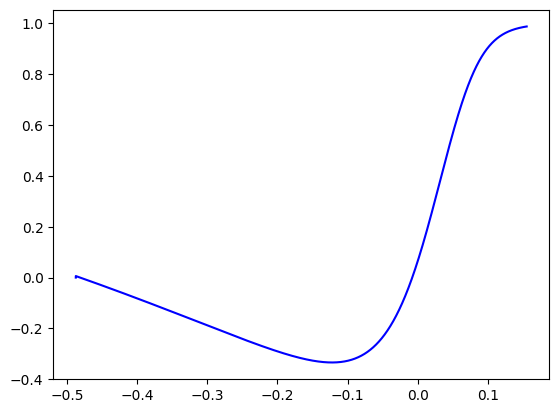

In [76]:
i = 10

x = X[i]  # Forward log moneyness
w = W[i]  # Total implied variance
svi = vol.SVI.calibrate(x, w)

# Create a grid of forward log moneyness values
grid = np.linspace(np.min(x), np.max(x), 10_000)

itv = svi(grid)

iv = np.sqrt(itv / T[i]) 
strikes = np.exp(grid) * F[0]
dx = strikes[1] - strikes[0]

cdf_values = np.diff(bs_call_price(F[0], iv, T[i], strikes), n=1) / dx + 1

cdf_interp = interp.interp1d(strikes[1:], cdf_values, kind='linear', bounds_error=False, fill_value=(0, 1))
qf_interp = interp.interp1d(cdf_values, strikes[1:], kind='linear', bounds_error=False, fill_value=(strikes[1], strikes[-1]))

marginal = Density(cdf_interp, qf_interp)

plt.plot(grid, marginal.cdf(strikes), color='blue')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


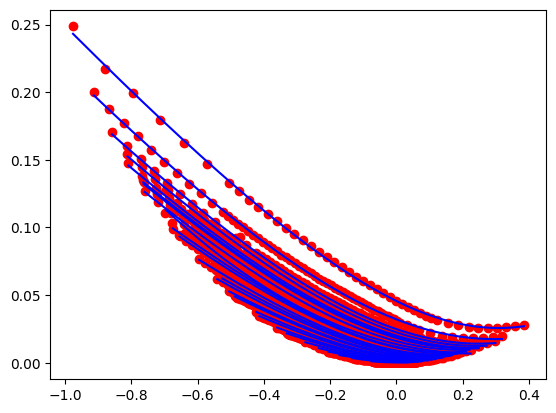

In [62]:
# Cell 5 - Complete the loop with proper formulas
svi_dict = {}

for i in range(len(T)):
    
    x = X[i]  # Forward log moneyness
    w = W[i]  # Total implied variance
    svi = vol.SVI.calibrate(x, w)
    
    # Create a grid of forward log moneyness values
    grid = np.linspace(np.min(x), np.max(x), 10_000)
    
    # Get total implied variance from SVI function
    itv = svi(grid)
    
    plt.plot(grid, itv, color='blue')
    plt.scatter(x, w, color='red')

    # Store the marginal for later use (you might want to add this)
    svi_dict[T[i]] = svi

In [3]:
#Create a reference model, which is a Brownian motion in our case
sv_model = StochasticVolatilityModel(100)
bass = SVBassLV(100, sv_model, {0.25: market_marginal_1, 0.7: market_marginal_2, 1: market_marginal_3})

#calibration example for the Heston market marginals
bass.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 5)

first BM is constructed
next interval with delta: 0.44999999999999996
bounds are: (array(11.58509573), array(185.06045466))
iter: 0, error: 0.049118444316525345
iter: 1, error: 0.013996646730540685
iter: 2, error: 0.0060458198264455865
iter: 3, error: 0.0027350708757705178
iter: 4, error: 0.0012774554995996779
Brenier map for maturity 0.7 is constructed error = 0.000617741663929805
next interval with delta: 0.30000000000000004
bounds are: (array(6.73727322), array(201.20321195))
iter: 0, error: 0.06591453133223402
iter: 1, error: 0.04012060907601278
iter: 2, error: 0.025339620948824026
iter: 3, error: 0.016879742522535324
iter: 4, error: 0.011697026096782137
iter: 5, error: 0.008327479770477764
iter: 6, error: 0.00604072891715246
iter: 7, error: 0.004441300359063094
iter: 8, error: 0.0032973244885075026
iter: 9, error: 0.0024659946150927814
iter: 10, error: 0.0018547322846907965
iter: 11, error: 0.0014014779546843714
iter: 12, error: 0.0010627809452857795
Brenier map for maturity 1.0 i

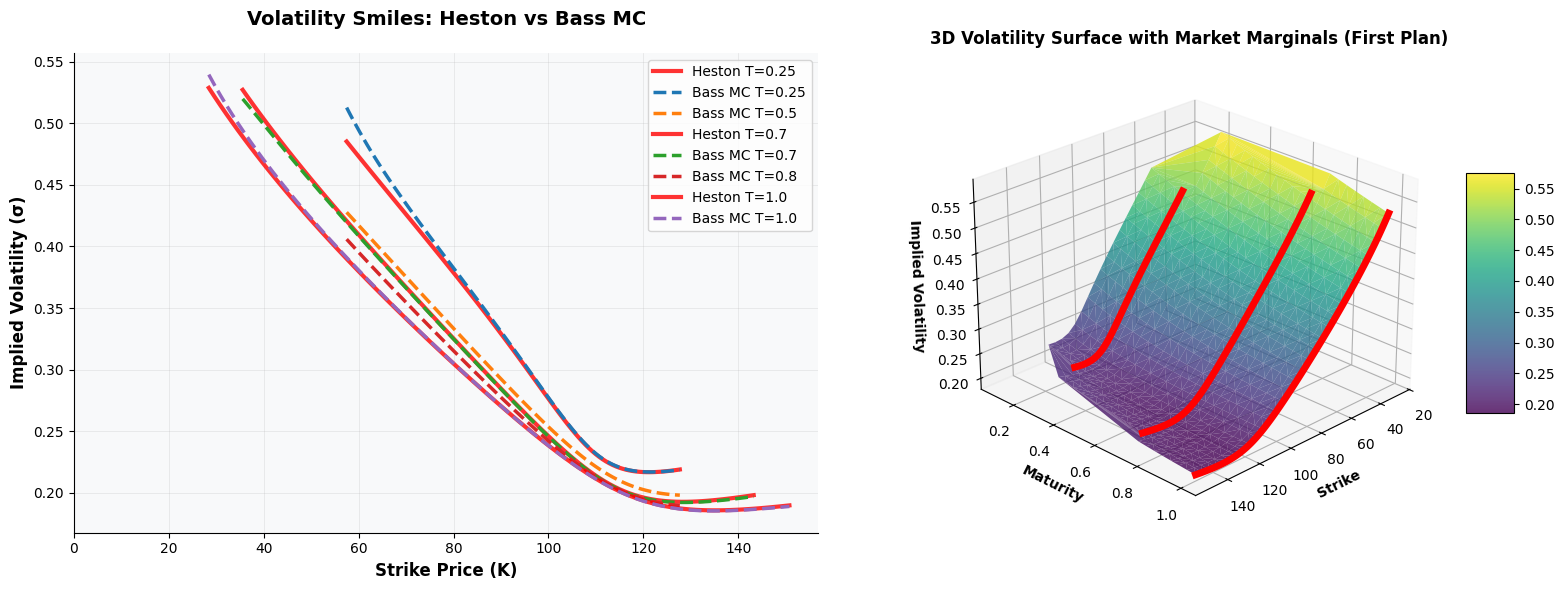

In [17]:
#Plotting
T_vals = [0.25, 0.5, 0.7, 0.8, 1.0]
T_model = [0.25, 0.7, 1.0] # Only these maturities have model plots
mc_data = {T: bass.simulate_smile(1_000_000, T) for T in T_vals} 
marginals = [market_marginal_1, None, market_marginal_2, None, market_marginal_3]

# Create figure with 3D subplot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)  # 2D plot
ax2 = fig.add_subplot(122, projection='3d')  # 3D surface plot

# 2D Plot with improved readability
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct color palette

for i, T in enumerate(T_vals):
    # Strike range
    marg = marginals[i] or market_marginal_1
    K = np.linspace(marg.qf(0.01), marg.qf(0.99), 100)
    
    # Plot model only for specific maturities (market smiles in red)
    if T in T_model:
        model_vol = model.implied_vol(T, K)
        ax1.plot(K, model_vol, color='red', linestyle='-', linewidth=3, alpha=0.8, 
                 label=f'Heston T={T}')
    
    # Always plot MC with different line style
    ax1.plot(K, mc_iv(model.s0, T, K, mc_data[T]), color=colors[i], linestyle='--', 
             linewidth=2.5, alpha=1, label=f'Bass MC T={T}')

# Improve 2D plot appearance
ax1.set_xlabel('Strike Price (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Implied Volatility (σ)', fontsize=12, fontweight='bold') 
ax1.set_title('Volatility Smiles: Heston vs Bass MC', fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set better axis limits and formatting
ax1.set_xlim(left=0)  # Start from 0 for strikes
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add subtle background color
ax1.set_facecolor('#f8f9fa')

# 3D Surface Plot with fixed strike grid, cut off by maturity-specific bounds
# Create fixed strike grid covering all maturities
all_strikes = []
for T, marginal in zip([0.25, 0.7, 1.0], [market_marginal_1, market_marginal_2, market_marginal_3]):
    all_strikes.extend([marginal.qf(0.01), marginal.qf(0.99)])

# Fixed strike range for all maturities
K_min, K_max = min(all_strikes), max(all_strikes)
strikes = np.linspace(K_min, K_max, 30)  # Fixed strike grid
maturities = np.linspace(0.1, 1.0, 25)   # Maturity grid

# Generate surface points with fixed strikes, cut off by maturity bounds
all_points = []
for T in maturities:
    # Find the closest maturity with defined bounds
    if T <= 0.25:
        marginal = market_marginal_1
    elif T <= 0.7:
        marginal = market_marginal_2
    else:
        marginal = market_marginal_3
    
    # Get bounds for this maturity
    K_min_T = marginal.qf(0.01)
    K_max_T = marginal.qf(0.99)
    
    # Filter strikes that fall within this maturity's bounds
    valid_strikes = strikes[(strikes >= K_min_T) & (strikes <= K_max_T)]
    
    for K in valid_strikes:
        try:
            vol = model.implied_vol(T, K)
            if not np.isnan(vol) and vol > 0:
                all_points.append([K, T, vol])
        except:
            continue

# Convert to numpy arrays for triangulation
all_points = np.array(all_points)
if len(all_points) > 0:
    K_valid = all_points[:, 0]
    T_valid = all_points[:, 1]
    vol_valid = all_points[:, 2]
    
    # Create triangulation
    from matplotlib.tri import Triangulation
    triang = Triangulation(K_valid, T_valid)
    
    # Plot triangulated surface using plot_trisurf
    surf = ax2.plot_trisurf(K_valid, T_valid, vol_valid, 
                           triangles=triang.triangles,
                           cmap='viridis', alpha=0.8, 
                           linewidth=0.5, antialiased=True)

# Add market marginals as solid lines on top of the surface (first plan)
for T, marginal in zip([0.25, 0.7, 1.0], [market_marginal_1, market_marginal_2, market_marginal_3]):
    K_range = np.linspace(marginal.qf(0.01), marginal.qf(0.99), 100)  # More points for smooth lines
    vol_line = model.implied_vol(T, K_range)
    
    # Plot the marginal line on top of the 3D surface with thick solid lines
    ax2.plot(K_range, [T] * len(K_range), vol_line, 
             color='red', linewidth=5, alpha=1.0, 
             label=f'Market Marginal T={T}', zorder=10)  # zorder=10 ensures lines are on top

# Customize 3D plot
ax2.set_xlabel('Strike', fontweight='bold')
ax2.set_ylabel('Maturity', fontweight='bold')
ax2.set_zlabel('Implied Volatility', fontweight='bold')
ax2.set_title('3D Volatility Surface with Market Marginals (First Plan)', fontweight='bold')
ax2.view_init(elev=25, azim=45)  # Set viewing angle

# Add colorbar for the surface
if len(all_points) > 0:
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()